# Machine learning compilation of quantum circuits -- experiments
> Flexible and efficient learning with JAX+numpy
- toc: true 
- badges: true
- comments: true
- categories: [qiskit, JAX, machine learning, compilation]
- image: images/upsidedown.jpg

# Introduction

In [1]:
#collapse
import jax.numpy as jnp
import numpy as np

from jax import random, value_and_grad, ops, jit, lax, vmap, grad, partial
key = random.PRNGKey(42)

# !pip install tensornetwork
# !pip install optax
# !pip install qiskit
# !pip install pylatexenc

import tensornetwork as tn
tn.set_default_backend('jax')

import optax

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit import Parameter
from qiskit.transpiler.passes.synthesis import UnitarySynthesis
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_gate

from scipy.stats import unitary_group

import matplotlib.pyplot as plt
import re

from pandas import DataFrame

## Motivation
Ever since I read the paper by L.Madden and A.Simonetto ([original preprint](http://arxiv.org/abs/2106.05649), [my review](https://idnm.github.io/blog/machine%20learning/compilation/qiskit/paper%20review/2021/07/22/Machine-learning-compilation-of-quantum-circuits.html)) I knew I want to do this kind of experiments myself. At first I hoped that there is a well-established framework where I can easily build quantum circuits and then optimize them efficiently. However, [I was not able to find a good fit for my problem](https://quantumcomputing.stackexchange.com/questions/20718/software-tools-to-train-quantum-circuits-with-parameters) (I later found [quimb](https://quimb.readthedocs.io/en/latest/index.html) which [might do what I want](https://quimb.readthedocs.io/en/latest/examples/ex_tn_train_circuit.html), but in the end I'm glad I worked things out from scratch). In the end I went for `numpy`+`JAX` combination which while being quite low-level was not a big problem to get working. 

Here I will give a walk thorough this implementation and show experiments with compilation of random unitaries. However, in my opinion truly interesting stuff is concerned with the compilation of special gates, say multi-controlled Toffolis on restricted connectivity. I intend to look at this kind problems in detail in a future blog post, also see [this preprint](http://arxiv.org/abs/2109.13223) for advances in that direction.


> *NOTE*: While I was working on my own experiments another [preprint appeared](http://arxiv.org/abs/2109.06770), by P.Rakyta and Z.Zimborás, which is very similar to the work of M&S in terms of numerical results. Despite the striking similarities these works are independent. As a bonus R&Z also provide a numerical package [SQUANDER](https://zenodo.org/record/4508680#.YVw-uYBBxNi) that allows to play with their framework for compilation of unitaries. You might wish to check that out if you are interested in doing some experiments yourself.


## The problem
OK, so first a brief recap of what is the compilation problem. Given a quantum circuit we need to find an equivalent one, which satisfies certain requirements. A typical restrictions are to use only some specific 2-qubits gates and to be compatible with limited connectivity. I gave a more detailed intro [here](https://idnm.github.io/blog/machine%20learning/compilation/qiskit/paper%20review/2021/07/22/Machine-learning-compilation-of-quantum-circuits.html). Here is a nearly-trivial example: a simple $CNOT$ gate 

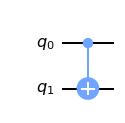

In [2]:
#collapse
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.draw(output='mpl')

can be decomposed in terms of the entangling $cz$ gate and single-qubit gates $rx, ry, rz$ as follows

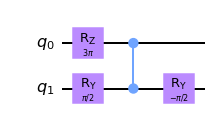

In [3]:
#collapse
qc_compiled = transpile(qc, basis_gates=['cz', 'rx', 'ry', 'rz'], optimization_level=3)
qc_compiled.draw(output='mpl')

Now, for generic $n$-qubit unitaries one needs exponentially many entangling gates for the compilation. More precisely, there is a [theoretical lower bound](https://dl.acm.org/doi/10.5555/968879.969163) $\#CNOTs\ge \frac14 \left(4^n-3n-1\right)$ on the amount of $CNOT$s required for compilation of any $n-$qubit unitary outside a measure zero set. Crucially, this measure zero set might in fact be of principal interest to quantum computing as it includes many operators featuring in most algorithms (such as multi-controlled gates). In this post I will only address compilation of random unitaries and discuss compilation of special cases in a future post. For later reference here is the function returning a theoretical lower bound

In [4]:
def TLB(n):
    return int((4**n-3*n-1)/4 + 1)

for n in range(1, 7):
    print('TLB for {}-qubit unitary is {}'.format(n, TLB(n)))

TLB for 1-qubit unitary is 1
TLB for 2-qubit unitary is 3
TLB for 3-qubit unitary is 14
TLB for 4-qubit unitary is 61
TLB for 5-qubit unitary is 253
TLB for 6-qubit unitary is 1020


Now, there is an algorithm called [quantum Shannon decomposition](https://arxiv.org/abs/quant-ph/0406176) to decompose an arbitary $n$-qubit unitary into a sequence of $CNOT$s and single-qubit rotations which requires roughly twice as many $CNOT$s as the theoretical lower bound implies. 

## 3-qubit example
As papers [M&S](http://arxiv.org/abs/2106.05649) and [R&Z](http://arxiv.org/abs/2109.06770) show, one can do better and eliminate the 2x overhead, at least numerically. Namely, it seems that precisely at the theoretical lower bound the exact or nearly-exact compilation is possible. Here is a real-life example. Consider the following 3-qubit circuit with $TLB(3)=14$ $CNOT$ gates

<img src="myimages/3qubitsequ.png" alt="Drawing" style="width: 800px;"/>

The claim is that with the appropriate choice of angles in rotation gates it can morph into *any* 3-qubit unitary. To find the corresponding angles it is sufficient to run a numerical optimization minimizing the fidelity between this circuit's unitary and the target unitary. This is rather impressive, but calls for many questions. Why choose $CNOT$ gates? Why place them in that exact order? It appears to be an empirical fact that precise location of entangling gates as well as their choice ($CNOT$, $CZ$, etc) makes little difference. Moreover, even restricted connectivity does not seem to force an overhead for compilation. I will back up these claims with numerical experiments.

## Contents
The rest of this post is divided into two parts. In the first I write some `numpy`/`JAX`/`qiskit` code that allows to construct and efficiently optimize circuits of interest. I try to give some explanations of the underlying numerical framework, but please do not mistake me for a real expert on the topic. Still, the resulting performance seems to be good enough to reproduce results of the existing preprints. This part can safely be skipped if you are only interested in the results.

In the second part of the post I will do a number of experiments compiling random unitaries with varying numbers of qubits, different types of entangling gates, restricted connectivity and try to draw some general lessons from them. 

In particular, I will illustrate the following points.
1. At least for a small number of qubits ($\le6$) very accurate compilation of random unitaries can be achieved precisely at the theoretical lower bound. This is a 2x improvement compared to the best theoretical algorithm, the quantum Shannon decomposition.
1. Simply counting the amount of entangling gates seems to serve as a good measure of the circuit expressivity.
1. It is likely that the arrangement and type of entangling gates used in the compilation of random unitaries is largely irrelevant.
1. Topological restrictions do not seem to cause any overhead on the compilation of random unitaries.

> *NOTE*: This blog post is also a fully-functional jupyter notebook. You can open it in Colab or download to you local machine and perform more experiments yourself!

# Numerical framework

## Entangling blocks

First let us define the basic 1- and 2-qubit gates in matrix form. For now you can safely ignore the use `jnp` arrays instead of `np` arrays.

In [5]:
# Matrix represntations of CNOT, CZ and single-qubit rotations

# Controlled-NOT (or controlled-X gate)
cx_mat = jnp.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, 1],
                    [0, 0, 1, 0]])

# Controlled-Z gate
cz_mat = jnp.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, -1]])

# Pauli matrices
x_mat = jnp.array([[0, 1],
                   [1, 0]])

y_mat = jnp.array([[0, -1j],
                   [1j, 0]], dtype=jnp.complex64)

z_mat = jnp.array([[1, 0],
                   [0, -1]])

# Rotation gates
def rx_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*x_mat*jnp.sin(a/2)

def ry_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*y_mat*jnp.sin(a/2)

def rz_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*z_mat*jnp.sin(a/2)

The circuits that we are going to train will be built out of two types of 2-qubit blocks, the controlled-Z and the controlled-NOT. Here are the definitions:

In [46]:
class block():
    """Two-qubits entangled block.
    
    Methods:
        circuit: gives equivalent `qiskit` circuit.
        unitary: gives `jax.numpy` unitary matrix of the circuit.
    """
    
    def __init__(self, gate_name, angles):
        self.gate_name = gate_name
        self.angles = angles
    
    def circuit(self):
        """Quantum circuit in `qiskit` corresponding to our block."""
        
        qc = QuantumCircuit(2)
        if self.gate_name == 'cx':
            qc.cx(0, 1)
        elif self.gate_name == 'cz':
            qc.cz(0, 1)
        else:
            print("Gate '{}' not yet supported'".format(self.gate_name))
        
        angles = np.array(self.angles) # convert from JAX array to numpy array if applicable.
        
        qc.ry(angles[0], 0)
        qc.rx(angles[1], 0)
        qc.ry(angles[2], 1)
        qc.rx(angles[3], 1)
        
        return qc
    
    def unitary(self):
        """JAX-compatible unitary corresponding to our block."""
        
        if self.gate_name == 'cx':
            entangling_matrix = cx_mat
        elif self.gate_name == 'cz':
            entangling_matrix = cz_mat
        else:
            print("Gate '{}' not yet supported'".format(self.gate_name))
        
        x_rotations = jnp.kron(rx_mat(self.angles[1]), rx_mat(self.angles[3]))
        y_rotations = jnp.kron(ry_mat(self.angles[0]), ry_mat(self.angles[2]))
        
        return x_rotations @ y_rotations @ entangling_matrix

Here is how they look:
`cz` block

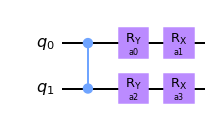

In [7]:
a0, a1, a2, a3 = [Parameter(a) for a in ['a0', 'a1', 'a2', 'a3']]
block('cz', [a0, a1, a2, a3]).circuit().draw(output='mpl')

and `cx` block

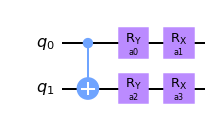

In [8]:
block('cx', [a0, a1, a2, a3]).circuit().draw(output='mpl')

Our `block` class can return a `qiskit` circuit and the corresponding unitary matrix. Of course we could have extracted the unitary from the circuit itself via `qiskit` API, but this would make the matrix representation incompatible with `JAX` which will be our workhorse for optimization. To the best of my knowledge currently it is only possible to use zero-order methods directly from `qiskit` which is a serious limitation. So at this point we needed a bit of wheel reinvention. Let's check that our implementation is consistent with `qiskit`:

In [9]:
# That's how you use random numbers with JAX. Don't worry if this is not familiar, not essential for our purposes.
angles = random.uniform(random.PRNGKey(0), shape=(4,), minval=0, maxval=2*jnp.pi)

for gate in ['cx', 'cz']:
    b = block(gate, angles)
    qc = b.circuit()
    qs_unitary = Operator(qc.reverse_bits()).data # Yes, we need to reverse bits in qiskit to match our conventions.
    our_unitary = b.unitary()
    print('qiskit unitary is the same as our unitary for block with gate {}: {}'.format(gate, jnp.allclose(qs_unitary, our_unitary)))

qiskit unitary is the same as our unitary for block with gate cx: True
qiskit unitary is the same as our unitary for block with gate cz: True


To match matrix representations of quantum circuits might be a headache as I discussed in [another post](https://idnm.github.io/blog/qiskit/tensor%20networks/quantum%20concepts/2021/08/18/Matrix-representation-of-quantum-circuits.html), so this was a necessary check to do.

Our two building blocks (`cz` and `cx`) only differ by the type of the two-qubit gate. The circuits that we are going to build seem to do equally well for any choice of two-qubit gate. I will mostly use `cz` gate because it is symmetric under the swap of qubits, but I will also occasionally bring up the `cx` gate to illustrate that it has the same performance. Angles $a_0$-$a_3$ are going to be optimized.

## Optimization with `JAX`

### A word about `JAX`

What is `JAX`? Well, I personally think of it as `numpy` on steroids. You can check out [the official documentation](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) or numerous nice overwievs on the web. For our purposes two key features of `JAX` are
1. Autograd.  
2. JIT or just-in-time compilation.

Autograd allows to define functions the same way you do in `numpy` and have analytic derivatives available with no extra coding on your side. At the moment `grad` function can only be applied to real scalars. For example, let us define the absolute value of the trace of `cx` block as function of rotations gate angles

In [10]:
def block_tr_abs(angles):
    b = block('cx', angles)
    tr = jnp.trace(b.unitary())
    return jnp.abs(tr)

Since everything so far has been defined using `jax.numpy` we have immediate access to the gradient of this function

In [11]:
grad(block_tr_abs)([0.,1.,2.,3.])

[DeviceArray(0.03655498, dtype=float32),
 DeviceArray(-0.25903472, dtype=float32),
 DeviceArray(-0.7384602, dtype=float32),
 DeviceArray(-7.450581e-09, dtype=float32)]

Autograd feature of `JAX` allows us to just define the loss function associated with our circuit in plain `numpy` terms and use advanced first-order optimizers such as Adam out of the box.

The next crucial ingredient is `jit`-compilation. When used with a bit of care, it allows to speed up evaluation of similar expression by orders of magnitude. For example let us compare runtimes of the `jit`ted and un`jit`ted versions of our trace function. Let's first define a sample of random 
angles

In [12]:
test_angles = random.uniform(random.PRNGKey(0), shape=(1000, 4), minval=0, maxval=2*jnp.pi)

and now time evaluation of un`jit`ted trace function

In [13]:
%%time
for angles in test_angles:
    block_tr_abs(angles)

CPU times: user 13.4 s, sys: 1.08 s, total: 14.5 s
Wall time: 12.3 s


Now awe to the power of `jit`!

In [14]:
%%time
jit_block_tr_abs = jit(block_tr_abs)
for angles in test_angles:
    jit_block_tr_abs(angles)

CPU times: user 162 ms, sys: 4.41 ms, total: 166 ms
Wall time: 147 ms


What happened here is that during the first call to the `jit`ted function it's efficient `XLA` version was compiled and then used to evaluate all subsequent calls. 

### Gradient descent

We will use the following measure of discrepancy between two unitaries $disc(U, V) = 1-\frac1{N}\operatorname{Tr}\left( U^\dagger V\right)$ where $U,V$ are $N\times N$ matrices. It is normalized so that $disc(U,U)=0$ and $disc(U,V)=0$ when $U$ and $V$ are orthogonal. Note that this measure is insensitive to global phases.

In [15]:
def disc(U, U_target):
    n = U_target.shape[0]
    return 1-jnp.abs((U.conj() * U_target).sum())/n

Here is the optimization routine that we are 
going to use. It is pretty straightforward and I will not give much explanations, but illustrate with an example.

In [16]:
@partial(jit, static_argnums=(0, 1, )) # <--- Here is where the magic happens! 
                                       # Remove this line and everything will run 1000 times slower:)
    
def unitary_update(loss_and_grad, opt, opt_state, angles):
    """Single update step."""
    
    loss, grads = loss_and_grad(angles)
    updates, opt_state = opt.update(grads, opt_state)
    angles = optax.apply_updates(angles, updates)
    return angles, opt_state, loss

def unitary_learn(U_func, U_target, n_angles, 
                  init_angles=None, key=random.PRNGKey(0),
                  learning_rate = 0.01, num_iterations=5000, 
                  target_disc = 1e-10):
    
    """Use Adam optimizer to minimize discrepancy between pamaterzied unitary and targe unitary.
    
    Args:
        U_func: function of angles returning univary matrix.
        U_target: unitary matrix to approximate.
        n_angles: total number of angles (parameters) in U_func.
        init_angles: intial angles for gradient descent. If not provided chosen at random.
        key: random seed to use for inizialization of initial angles.
        learning_rate: learning rate in Adam optimizer.
        num_iterations: maximum number of iterations.
        target_disc: stop optimization if discrepancy drops below target_disc.
    
    Returns: tuple (angles_history, loss_history) where
        angles_history: list of angles (parameters) at each iteration step.
        loss_history: values of loss_function at each iteration step.
    
    """
    
    # If initial angles are not provided generate them at random.
    if init_angles is None:
        key = random.PRNGKey(0)
        angles = random.uniform(key, shape=(n_angles,), minval=0, maxval=2*jnp.pi)
    else:
        angles = init_angles
    
    # Loss function to minimize is dicrepancy defined above.
    loss_func = lambda angles: disc(U_func(angles), U_target)
    loss_and_grad = value_and_grad(loss_func)

    # Optimizer is taken from the `optax` library and its use is self-explanotory.
    opt = optax.adam(learning_rate)
    opt_state = opt.init(angles)
    
    # Optimization cycle
    angles_history=[]
    loss_history=[]
    for _ in range(num_iterations):
        angles, opt_state, loss = unitary_update(loss_and_grad, opt, opt_state, angles)
        angles_history.append(angles)
        loss_history.append(loss)
        if loss < target_disc:
            break
    
    return angles_history, loss_history

OK, now a very simple example. Say we want to find a $ZXZ$ decomposition of  $Y$-gate. Define:

In [17]:
def zxz_ansatz(angles):
    return rz_mat(angles[0]) @ rx_mat(angles[1]) @ rz_mat(angles[2])

Learning is now very simple: we give `unitary_learn` the ansatz unitary as function of angles, the target unitary and also explicitly the number of parameters to be trained:

In [18]:
angles_history, loss_history = unitary_learn(zxz_ansatz, y_mat, 3)

We can visualize the learning progress as follows:

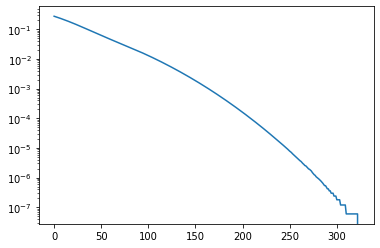

In [19]:
plt.plot(loss_history)
plt.yscale('log')

The learned angles in $ZXZ$ decomposition are

In [20]:
angles_history[-1]

DeviceArray([6.59216  , 3.1411407, 3.4505684], dtype=float32)

It is not difficult to check directly that the result is equal to the $Y$ matrix up to a global phase with reasonable accuracy, indeed

In [21]:
jnp.around(1j*zxz_ansatz(angles_history[-1]), 3)

DeviceArray([[0.+0.j, 0.-1.j],
             [0.+1.j, 0.+0.j]], dtype=complex64)

## Quantum circuits with `numpy`

Now it's time to build full quantum circuits. We will think of a quantum circuit on $n$ qubits as a tensor with $2*n$ legs. First $n$ legs correspond to *output* and last to $n$ input. This is illustrated at the picture.

<img src="myimages/mlexperiments/tensor.svg" alt="Drawing" style="width: 540px;"/>

It is natural for input legs to be on the left because in matrix notation a unitary $U$ acts on a state $\psi$ by left multiplication $U\psi$. On the other hand note that quantum circuits are usually drawn left-to-right and to compare the two descriptions a left-right reflection must be made.

Suppose now that given an $n-$qubit circuit $U$ we want to append an additional $m-$qubit gate $V$ at the end. Here is a concrete example (a picture is worth a thousand words!)

<img src="myimages/mlexperiments/tensor_contraction.svg" alt="Drawing" style="width: 540px;"/>
Several things to keep in mind:

1. To append gate $V$ at the end in quantum circuit notation, we need to draw it on the left here.
1. Tensor legs are joined by `numpy`'s `tensordot` operation. Which axes to contract is clear from the picture -- we need to join axes 2, 3 of $V$ to 1, 3 of $U$.
1. In the resulting tensor the output legs are not in the correct order. Instead of being numbered from top to bottom after `tesordot` first several axes are those of $V$ and the remaining are uncontracted output axes of $U$ (take a look at the leftmost column of numbers). This needs to be corrected by explicit transposition of output axes.
1. The final caveat is that if some of the legs connecting gate to the circuit are twisted the output legs needs to be transposed accordingly. Here is an example

<img src="myimages/mlexperiments/tensor_contraction_twisted.svg" alt="Drawing" style="width: 540px;"/>

Here is the code that implements this program.

In [22]:
def gate_transposition(placement):
    """Determine transposition associated with initial placement of gate."""
    
    position_index = [(placement[i], i) for i in range(len(placement))]
    position_index.sort()
    transposition = [i for _,i in position_index]
    return transposition

def transposition(n_qubits, placement):
    """Return a transposition that relabels tensor axes correctly.
    Example (from the figure above): n=6, placement=[1, 3] gives [2, 0, 3, 1, 4, 5].
    Twiseted: n=6, placement=[3, 1] gives [2, 1, 3, 0, 4, 5]."""
    
    gate_width = len(placement)
    
    t = list(range(gate_width, n_qubits))
    
    for position, insertion in zip(sorted(placement), gate_transposition(placement)):
        t.insert(position, insertion)

    return t

def apply_gate_to_tensor(gate, tensor, placement):
    """Append `gate` to `tensor` along legs specified by `placement`. Transpose the output axes properly."""
    
    gate_width = int(len(gate.shape)/2)
    tensor_width = int(len(tensor.shape)/2)
    # contraction axes for `tensor` are input axes (=last half of all axes)
    gate_contraction_axes = list(range(gate_width, 2*gate_width)) 

    contraction = jnp.tensordot(gate, tensor, axes=[gate_contraction_axes, placement])
    t = transposition(tensor_width, placement) + list(range(tensor_width, 2*tensor_width)) # input(=last half) indices are intact

    return jnp.transpose(contraction, axes=t)

Now, using this tensor language we will construct unitary matrices corresponding to our ansatz circuits. To specify the ansatz we must supply the number of qubits in the circuit, type of entangling blocks to use and arrangement of these blocks. 

The simplest way to specify arrangement would be to just give a list like `[[0,1], [1, 3], [2, 1]]` etc of pairs of qubits to put entangling blocks on to. However for performance reasons I need to make it more complicated. To construct a matrix for our quantum circuit we basically need to loop over all entangling gates and append them one by one. When using `JAX` plain python loops are simply unrolled and then compiled. For large loops this leads to very large compilation times. If there is no structure in how we place our gates in the circuit this is probably the best one can do. However, we can be more efficient than that if there is a structure. Take a look at this picture

In [23]:
#collapse
qc = QuantumCircuit(4)
i = 0
for _ in range(11):
    qc.cx(i,i+1)
    i = (i+1) % 3
    if i % 3 == 0:
        qc.barrier()
    
qc.draw()

░                 ░                 ░           
q_0: ──■─────────────░───■─────────────░───■─────────────░───■───────
     ┌─┴─┐           ░ ┌─┴─┐           ░ ┌─┴─┐           ░ ┌─┴─┐     
q_1: ┤ X ├──■────────░─┤ X ├──■────────░─┤ X ├──■────────░─┤ X ├──■──
     └───┘┌─┴─┐      ░ └───┘┌─┴─┐      ░ └───┘┌─┴─┐      ░ └───┘┌─┴─┐
q_2: ─────┤ X ├──■───░──────┤ X ├──■───░──────┤ X ├──■───░──────┤ X ├
          └───┘┌─┴─┐ ░      └───┘┌─┴─┐ ░      └───┘┌─┴─┐ ░      └───┘
q_3: ──────────┤ X ├─░───────────┤ X ├─░───────────┤ X ├─░───────────
               └───┘ ░           └───┘ ░           └───┘ ░

Here $CNOT$s are just placeholders for any entangling block of our interest. There is a regular pattern. Most of the circuit consists of identical layers up to a couple of final gates. Construction and optimization of such circuits with `JAX` can be made way more efficient by using `lax.fori_loop` ([see here for docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html)) or a similar construct. This allows to exploit the regularity and reduce the compilation time dramatically.

The price to pay is a bit of a hassle in separating all gates into regular ones and the remainder. My core function `build_unitary` accepts the regular layers as an argument `layer_placements=[layer, number_of_repetitions]` and the remainder gates are described by `free_placements`. Also, we need some way to access all parameters (angles) in our circuit. I chose the simplest approach here, to supply angles as a 1d array, but internally they play a bit different roles so there is also a function `split_angles` to separate a 1d array of all angles into several logical blocks.

OK, so here is the code. Examples are found in the end of this section.

In [24]:
def split_angles(angles, num_qubits, layer_len, num_layers, free_placements_len):
    """Splits 1d array of all angles in a circuit into four groups.
    
    Args:
        angles: all angles in a circuit as 1d array.
        num_qubits: number of qubits in a circuit.
        layer_len: length (depth) of a single layer in a circuit.
        num_layers: number of repeated layers.
        free_placements_len: number of entanglig blocks not in layers.
        
    Returns:  a tuple (surface_angles, layers_angles, free_block_angles) where
        surface_angles: angles in initial single-qubit blocks.
        block_angles: angles of all entangling blocks.
        layers_angles: angles for entangling blocks that are parts of complete layers.
        free_block_angles: angles of remaining entangling blocks.
    """ 
    
    surface_angles = angles[:3*num_qubits].reshape(num_qubits, 3)
    block_angles = angles[3*num_qubits:].reshape(-1, 4)
    layers_angles = block_angles[:layer_len*num_layers].reshape(num_layers, layer_len, 4)
    free_block_angles = block_angles[layer_len*num_layers:]
    
    return surface_angles, block_angles, layers_angles, free_block_angles

def build_unitary(num_qubits, block_type, angles, layer_placements=[[], 0], free_placements=[]):
    """
    Builds `JAX`-compatible unitary matrix of a quantum circuit.
   
    Arguments specify structure of the circuit and values of parameters.
    
    Args:
        num_qubits: number of qubits.
        block_type: type of entangling block to use. Currently only 'cx' and 'cz' are supported.
        angles: 1d array of all angle parameters in the circuit.
        layer_placements: a tuple (single_layer, n) where `single_layer` specifies 
            positions of several entangling blocks and `n` how many time to repeat each layer.
        free_placements: Positions of entangling blocks that do no belong to layers.

    Returns:
        A `jax.numpy` unitary matrix of the quantum circuit.
    """
    
    layer, num_layers = layer_placements
    
    layer_depth = len(layer)    
    num_blocks = len(layer)*num_layers+len(free_placements) # Count all entangling blocks.
    
    # Divides 1d array of all angles into three logically distinct groups.
    
    surface_angles, _, layers_angles, free_block_angles = split_angles(angles, num_qubits, 
                                                                    len(layer), num_layers, len(free_placements))
    
    # Initizlizes identity matrix of the proper size.
    
    u = jnp.identity(2**num_qubits).reshape([2]*num_qubits*2)
    
    # Unitary matrix is built in three steps. 
    # First, 3 single-qubit gates are applied to each qubit.
    # Second, all entangling blocks that are parts of layers are applied.
    # Finally, remainder blocks that a not parts any layer are applied.
    
    # Initial round of single-qubit gates
    
    for i, a in enumerate(surface_angles):
        gate = rz_mat(a[2]) @ rx_mat(a[1]) @ rz_mat(a[0])
        u = apply_gate_to_tensor(gate, u, [i])
    
    # Sequence of layers wrapped in `fori_loop`.
    # Using `fori_loop` instead of plain `for` loop reduces the compilation time significantly.
    # To use `fori_loop` it is convenient to define a separate function that applies a whole layer of gates.
    

    def apply_layer(i, u, layer, layers_angles):
        """Apply several gates to a given quantum circuit.
        
        Supplying the totality of `layers_angles` makes 
        the function compatible with `fori_loop`.
        
        Args:
            i: index of the layer.
            u: matrix to apply gates to.
            layer: positions of all gates to be applied.
            layers_angles: angles of all layers.        
        """
        layer_angles = layers_angles[i]
    
        for block_angles, position in zip(layer_angles, layer):
            gate = block(block_type, block_angles).unitary().reshape(2,2,2,2) 
            u = apply_gate_to_tensor(gate, u, position)
            
        return u

    if num_layers>0:
        u = lax.fori_loop(0, num_layers, lambda i, u: apply_layer(i, u, layer, layers_angles), u)
    
    # Adds the remainding (free) entangling blocks.
    
    for angles, position in zip(free_block_angles, free_placements):
        gate = block(block_type, angles).unitary().reshape(2,2,2,2)
        u = apply_gate_to_tensor(gate, u, position)

    return u.reshape(2**num_qubits, 2**num_qubits)

## Layers

Here are a couple of simple functions to help define gate arrangements. The basic layer is `sequ_layer` which consists of entangling gates applied to each possible pair of two qubit gates enumerated by pairs $(i,j)$ with $i<j$.

In [25]:
def sequ_layer(num_qubits):
    return [[i,j] for i in range(num_qubits) for j in range(i+1, num_qubits)]

def fill_layers(layer, depth):
    num_complete_layers = depth // len(layer)
    complete_layers = [layer, num_complete_layers]
    incomplete_layer = layer[:depth % len(layer)]
    
    return complete_layers, incomplete_layer

Function `fill_layers` allows to specify how much entangling gates we want in total and splits them into complete layers (to be used as `layer_placements`) and possible remainder gates (that become `free_placements`). For example, a `sequ_layer` on three qubits consists of three gates at positions

In [26]:
sequ_layer(3)

[[0, 1], [0, 2], [1, 2]]

 If we want to have the sequ pattern and 10 entangling gates in total we can put three complete layers and a final single gate. `fill_layers` does just that

In [27]:
layer_placements, free_placements = fill_layers(sequ_layer(3), 10)
print(layer_placements)
print(free_placements)

[[[0, 1], [0, 2], [1, 2]], 3]
[[0, 1]]


## Packing everything together: ansatz circuits

Now that we have defined our building blocks and convenience functions to assemble them it is time to pack everything together and reap the harvest.

I will define `ansatz` class that assembles our building blocks according to a predefined pattern. It's `circuit` method gives a `qiskit` circuit which can be used for visualization and cross-checks. It's `unitary` attribute returns fully `jax`-compatible matrix representation of the same circuit. Finally, its `learn` method uses our optimization routine to approximate a target unitary. First the code, then an example.

In [28]:
class Ansatz():
    """Parametric quantum circuit.

    Ansatz/parametric circuit is defined by tupes of entangling blocks and their arrangement.
    Concrete values of parameters are not considered part of the ansatz. Class provides access
    to both `qiskit` version of the circuit and `jax.numpy` unitary matrix.

    Attributes:
        num_qubits: number of qubits
        block_type: type of entangling blocks
        num_angles: total number of angles (parameters) in the circuit.
        unitary: `jax.numpy` unitary matrix of the circuit as function of angles.
    
    Methods:
        circuit: `qiskit` version of the circuit.
        learn: numerical approximation of the target unitary.
    """
    
    def __init__(self, num_qubits, block_type, layer_placements=[[], 0], free_placements=[]):
        
        self.num_qubits = num_qubits
        self.block_type = block_type
        
        self.layer, self.num_layers = layer_placements
        self.free_placements = free_placements
        self.all_placements = self.layer*self.num_layers+free_placements
        
        self.num_angles = 3*num_qubits+4*len(self.all_placements)
        
        self.unitary = lambda angles: build_unitary(self.num_qubits, self.block_type, angles, 
                                                     layer_placements=[self.layer, self.num_layers], 
                                                     free_placements=self.free_placements)
    def circuit(self, angles=None): 
        """qiskit version circuit. If angles not specified a parametric circuit is constructed."""
        
        if angles is None:
            angles = np.array([Parameter('a{}'.format(i)) for i in range(self.num_angles)])
            
        surface_angles, block_angles, _, _ = split_angles(angles, self.num_qubits, 
                                                          len(self.layer), self.num_layers, 
                                                          len(self.free_placements))        
        
        qc = QuantumCircuit(self.num_qubits)
        
        # Initial round of single-qubit gates.
        
        for n, a in enumerate(surface_angles):
            qc.rz(a[0], n)
            qc.rx(a[1], n)
            qc.rz(a[2], n)
        
        # Entangling gates accoring to placements
        
        for a, p in zip(block_angles, self.all_placements):
            qc_block = block(self.block_type, a).circuit() 
            qc = qc.compose(qc_block, p)
            
        return qc
        
    def learn(self, u_target, **kwargs): 
        """Use numerical optimization to approximate u_target."""
        
        u_func = self.unitary
        return unitary_learn(u_func, u_target, self.num_angles, **kwargs)

Here is an example that should illustrate how all this can be used.

In [29]:
n_qubits = 3
block_type = 'cx'

# For technical reasons all entangling gates are divided into 'layers' and 'free' gates. 

single_layer = [[0, 1], [2, 1]] # We make single layer consisting of 'cx' block on qubits [0,1]
                                # followed by reversed 'cx' block on qubits [1,2].
    
layers = [single_layer, 3] # The layer is repeated 3 times.

free_placements = [[1, 0], [0, 1], [1, 2], [2, 1]] # Apeend remaining `free placements` a.

anz = Ansatz(n_qubits, block_type, layer_placements=layers, free_placements=free_placements)

Here is what resulting circuit looks like.

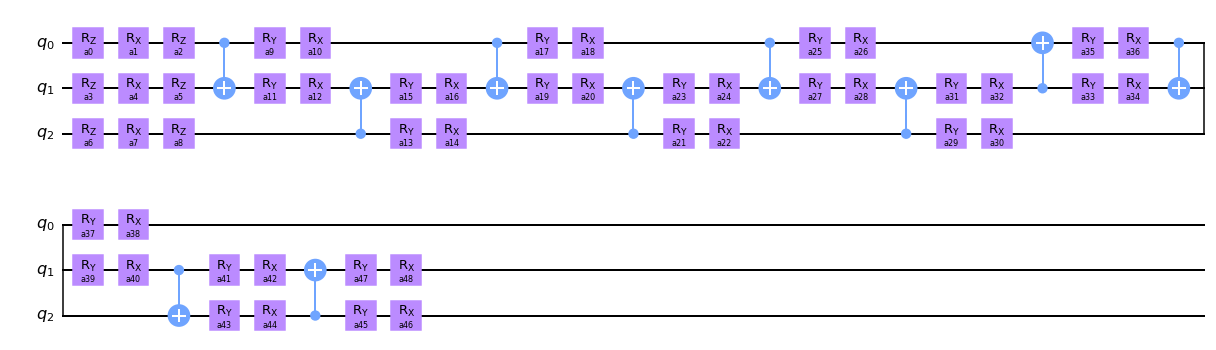

In [30]:
anz.circuit().draw(output='mpl')

Just to make sure let us check that the unitary matrix of this circuit extracted from qiskit agrees with our own implementation for a random set of angles.

In [31]:
angles = random.uniform(random.PRNGKey(0), shape=(anz.num_angles,), minval=0,maxval=2*jnp.pi)

qs_u = Operator(anz.circuit(angles).reverse_bits()).data # qiskit matrix representation
our_u = anz.unitary(angles) # our matrix representation
print(jnp.allclose(qs_u, our_u, rtol=1e-6, atol=1e-7))

True


# Experiments

Now the hard work is behind and we can reap the benefits. I will go through a series of examples. Primary goal is to back up the claims from the introduction about reaching the theoretical lower bound, agile performance on restricted topology etc. But I will also try to make clear how my code can be used if you wish to do a little experimenting with it.

## Learning 2-qubit random unitary

Let's start by learning a random 2-qubits unitary. First, define one.

In [32]:
u_target = unitary_group.rvs(4, random_state=0)

Here is the parametrized circuit we are going to use. `cz` means that the entangling gate is controlled-Z while `free_placements` are just positions where to put these entangling gates. There isn't much choice for 2 qubits as you could guess. I will explain why I call these `free_placements` a bit later. 

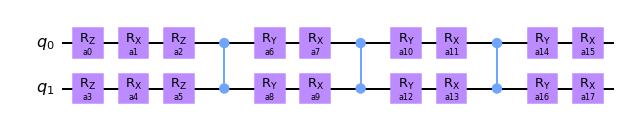

In [33]:
anz = Ansatz(2, 'cz', free_placements=[[0,1], [0,1], [0, 1]])
anz.circuit().draw(output='mpl')

The learning process is easy as pie:

CPU times: user 2.77 s, sys: 27.1 ms, total: 2.8 s
Wall time: 2.84 s


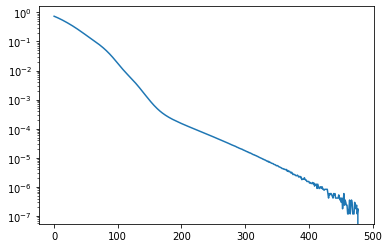

In [34]:
%%time

angles_history, loss_history = anz.learn(u_target)
plt.plot(loss_history)
plt.yscale('log')

The graph shows that we achieve great fidelity in under 500 iterations. 

What if you do not believe me? Is there a way to tell this plot indeed reflects a successful compilation without looking under the hood? Since you're asking, I will double-check using pure `qiskit`:

In [35]:
angles = angles_history[-1] # Last(=best) angles in the optimization process.
qc = anz.circuit(angles) # gnuine qiskit circuit. 
u_qs = Operator(qc.reverse_bits()).data # qiskit API to extract the unitary matrix.
disc(u_qs, u_target) # OK, I guess here you have believe I've implemented the cost function properly.

DeviceArray(2.3841858e-07, dtype=float32)

Similar checks can be done in more complicated scenarios below. You can try various experiments here. Some ideas:
1. Changing gate type from `cz` to `cx` (should not affect the result).
1. Decreasing the number of layers (fidelity won't be nearly as good).
1. Increase the number of layers (same fidelity with less iterations).

## Learning 3-qubit random unitary

I advertised in the introduction that with just 14 entangling gates any 3-qubit unitary can be nearly perfectly approximated. Let me back up this claim. Here is how we can construct the corresponding ansatz.

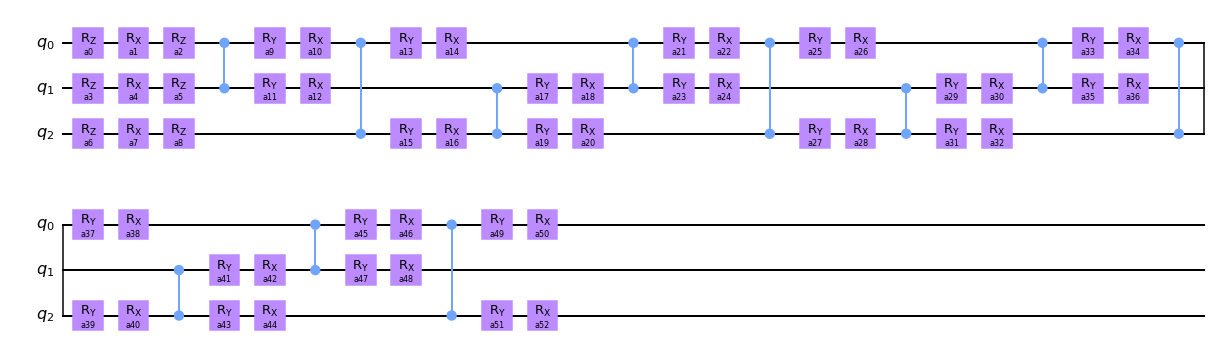

In [36]:
num_qubits = 3
block_type = 'cz'
depth = 14
layer_placemets, free_placements = fill_layers(sequ_layer(num_qubits), depth)

anz = Ansatz(num_qubits, block_type, layer_placements=layer_placements, free_placements=free_placements)
anz.circuit().draw(output='mpl')

Layer placements require a bit of unpacking. This is an implementation detail I didn't take enough care to hide. For technical reasons I explained in the numerical section optimization is much faster when gates are arranged in a regular pattern. The pattern we use here is called `sequ_layer` and for three qubits is simply

In [37]:
sequ_layer(num_qubits)

[[0, 1], [0, 2], [1, 2]]

i.e. it just lists all possible pairs of three qubits. However, since 14 % 3 = 2 the two last gates do not fit into the regular pattern and require a bit of a special treatment. This is what the function `fill_layers` does for us. Indeed

In [38]:
layer_placements, free_placements = fill_layers(sequ_layer(num_qubits), depth)
print('basic layer is repeated four times:', layer_placements)
print('remaining blocks reside at positions:', free_placements)

basic layer is repeated four times: [[[0, 1], [0, 2], [1, 2]], 4]
remaining blocks reside at positions: [[0, 1], [0, 2]]


OK, now let the circuit learn.

CPU times: user 9.9 s, sys: 167 ms, total: 10.1 s
Wall time: 9.31 s


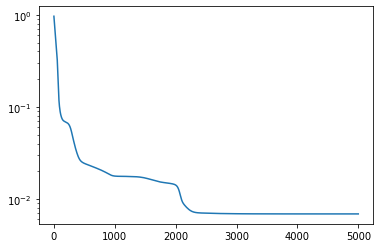

In [39]:
%%time

u_target = unitary_group.rvs(2**num_qubits, random_state=0)
angles_history, loss_history = anz.learn(u_target)

plt.plot(loss_history)
plt.yscale('log')

OK, I hope this does convince you that our ansatz was indeed good enough! Another interesting thing to do is to make a sweep to see how the fidelity increases (error drops) with the number of layers.

CPU times: user 4min 8s, sys: 7.19 s, total: 4min 15s
Wall time: 3min 56s


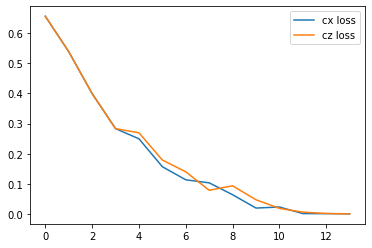

In [40]:
%%time

best_loss = [[], []]
for depth in range(14): # TLB(3)=14
    layer_placemets, free_placements = fill_layers(sequ_layer(n_qubits), depth)
    for i, block_type in enumerate(['cx', 'cz']):
        anz = Ansatz(num_qubits, block_type, layer_placements=layer_placemets, free_placements=free_placements)
        angles, loss_history = anz.learn(u_target, target_disc=10e-4)
        best_loss[i].append(min(loss_history))

plt.plot(best_loss[0], label='cx loss')
plt.plot(best_loss[1], label='cz loss')
plt.legend()

One lesson here is that both types of two-qubits gate perform similarly well at all depths. This is not surprising for because `cx` and `cz` gates can be related by single-qubit Hadamard transformations. It would be interesting to see if other two-qubit gates perform differently.

Another important observation is that the best fidelity is a monotonic function of the the amount of two-qubit gates. There is some work on variational algorithms testing various metrics that would adequately reflect expressivity of the ansatz. I think that plain number of $CNOT$ gates should in fact be a fantastic and simple metric for this.

## Learning 6-qubit random unitary

I do know that 3 is followed by 4, but shall we perhaps get more ambitious? Let's try to compile a 6-qubit random unitary (you can try to go higher if your machine allows):

CPU times: user 5min 44s, sys: 1min 3s, total: 6min 47s
Wall time: 6min 42s


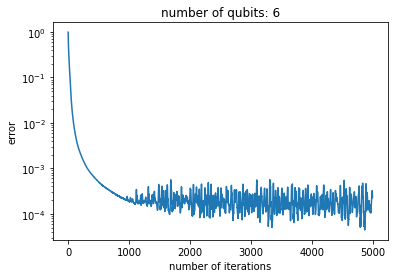

In [41]:
%%time

num_qubits = 6
depth = TLB(num_qubits) # 1020 for 6 qubits
layer_placements, free_placements = fill_layers(sequ_layer(num_qubits), depth)

u_target = unitary_group.rvs(2**num_qubits, random_state=0)
anz = Ansatz(num_qubits, 'cz', layer_placements=layer_placements, free_placements=free_placements)

angles_history, loss_history = anz.learn(u_target, num_iterations=5000)

plt.title('number of qubits: {}'.format(num_qubits))
plt.xlabel('number of iterations')
plt.ylabel('error')
plt.plot(loss_history)
plt.yscale('log')

Note that depth of the theoretical lower bound for 6 qubits is $TLB(6)=1020$ which implies that there are $\approx 4000$ parameters in our ansatz. On my modest laptop the training completes in about 10 minutes. Of course I would not claim this to be the cutting edge, but our `JAX` setup seems to be competitive at the scale (3-6 qubits) addressed in literature.

## Restricted topology

Of of the  very remarkable features of this approach is that topology restrictions do not seem to bring any overhead to compilation of random unitaries. To make the point and illustrate this claim I will consider the least connected topology I can think of, the chain topology. The corresponding layer consists of all pairs of adjacent qubits.

In [42]:
def chain_layer(num_qubits):
    return [(i,i+1) for i in range(num_qubits-1)]

Here is a 6-qubit illustration.

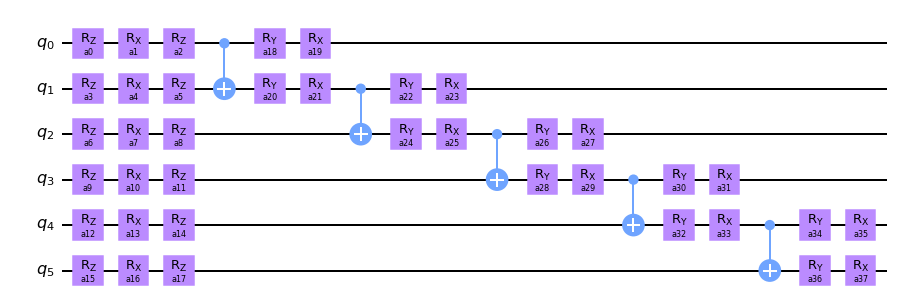

In [43]:
Ansatz(6, 'cx', layer_placements=[chain_layer(6), 1]).circuit().draw(output='mpl')

Here I drew a single layer consisting of 5 blocks. To reach the theoretical lower bound requires to stack together 1020/5=204 layers. Let's do that and see how the learning goes.

In [44]:
%%time

depth = TLB(num_qubits)
layer_placements, free_placements = fill_layers(chain_layer(num_qubits), depth)

u_target = unitary_group.rvs(2**num_qubits, random_state=0)
anz = Ansatz(num_qubits, 'cx', layer_placements=layer_placements, free_placements=free_placements)

angles_history_chain, loss_history_chain = anz.learn(u_target)

CPU times: user 5min 38s, sys: 1min 5s, total: 6min 44s
Wall time: 6min 34s


Let's compare the results with the previously considered fully connected topology.

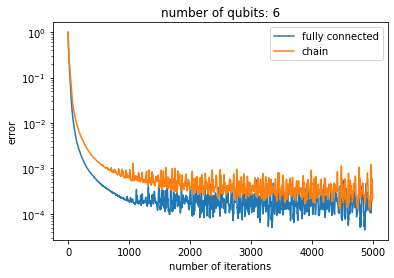

In [45]:
plt.title('number of qubits: {}'.format(num_qubits))
plt.xlabel('number of iterations')
plt.ylabel('error')
plt.plot(loss_history, label='fully connected')
plt.plot(loss_history_chain, label='chain')
plt.legend()
plt.yscale('log')

As you can see, the chain topology performs only slightly worse than the fully connected topology which seems truly remarkable.

# Remaks

1. Qiskit -- zero order optimization
1. Optimization of unitaries -- small scale. Used as part of larger-scale compilation or for compilation of special gates.
1. Mention squandr
1. Acknowledge Ilia